In [1]:
# !pip install xgboost lightgbm imbalanced-learn seaborn matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score, roc_auc_score, RocCurveDisplay
)
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('train1.csv').drop('id', axis=1)
df_test = pd.read_csv('test.csv').drop('id', axis=1)

Предработка: маппинг категорий

In [3]:
v_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
v_damage_mapping = {'Yes': True, 'No': False}
bool_mapping = {1: True, 0: False}

df['Vehicle_Age'] = df['Vehicle_Age'].map(v_age_mapping)
df_test['Vehicle_Age'] = df_test['Vehicle_Age'].map(v_age_mapping)

df['Vehicle_Damage'] = df['Vehicle_Damage'].map(v_damage_mapping)
df_test['Vehicle_Damage'] = df_test['Vehicle_Damage'].map(v_damage_mapping)

df['Driving_License'] = df['Driving_License'].map(bool_mapping)
df['Previously_Insured'] = df['Previously_Insured'].map(bool_mapping)
df_test['Driving_License'] = df_test['Driving_License'].map(bool_mapping)
df_test['Previously_Insured'] = df_test['Previously_Insured'].map(bool_mapping)

 Категориальные признаки

In [4]:
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('object')
df['Region_Code'] = df['Region_Code'].astype('object')
df_test['Policy_Sales_Channel'] = df_test['Policy_Sales_Channel'].astype('object')
df_test['Region_Code'] = df_test['Region_Code'].astype('object')

Масштабирование числовых признаков


In [5]:
numerical_features = df.select_dtypes(exclude=['object', 'bool']).drop('Response', axis=1).columns

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])
df_test[numerical_features] = scaler.transform(df_test[numerical_features])

One-hot кодирование

In [6]:
df = pd.get_dummies(df, drop_first=True)
df_test = pd.get_dummies(df_test, drop_first=True)

Выравнивание признаков train/test

In [7]:
train_cols = df.columns
test_cols = df_test.columns
missing_cols_train = set(test_cols) - set(train_cols)
missing_cols_test = set(train_cols) - set(test_cols)

df.drop(columns=missing_cols_test, inplace=True)
df_test.drop(columns=missing_cols_train, inplace=True)

Создание X, y

In [8]:
X_train = df.drop('Response', axis=1)
y_train = df['Response']
X_test = df_test.drop('Response', axis=1)
y_test = df_test['Response']

Удалим Vehicle_Age

In [9]:
X_train = X_train.drop('Vehicle_Age', axis=1)
X_test = X_test.drop('Vehicle_Age', axis=1)

Балансировка классов (SMOTE)

In [10]:
# Проверим наличие NaN
print("Train NaN:\n", X_train.isna().sum())
print("\nTest NaN:\n", X_test.isna().sum())

# Удалим строки с NaN, если они есть
X_train.dropna(inplace=True)
y_train = y_train.loc[X_train.index]  # синхронизируем y

X_test.dropna(inplace=True)
y_test = y_test.loc[X_test.index]


Train NaN:
 Age                           0
Driving_License               0
Previously_Insured            0
Vehicle_Damage                0
Annual_Premium                0
                             ..
Policy_Sales_Channel_157.0    0
Policy_Sales_Channel_158.0    0
Policy_Sales_Channel_159.0    0
Policy_Sales_Channel_160.0    0
Policy_Sales_Channel_163.0    0
Length: 206, dtype: int64

Test NaN:
 Age                           0
Driving_License               0
Previously_Insured            0
Vehicle_Damage                0
Annual_Premium                0
                             ..
Policy_Sales_Channel_157.0    0
Policy_Sales_Channel_158.0    0
Policy_Sales_Channel_159.0    0
Policy_Sales_Channel_160.0    0
Policy_Sales_Channel_163.0    0
Length: 206, dtype: int64


In [57]:
# уменьшим X_train до 100k перед SMOTE
X_small, _, y_small, _ = train_test_split(X_train, y_train, train_size=200_000, stratify=y_train, random_state=37)

# Применим SMOTE только к уменьшенному
X_res, y_res = SMOTE(random_state=37).fit_resample(X_small, y_small)

In [58]:
print(X_res, y_res)

             Age  Driving_License  Previously_Insured  Vehicle_Damage  \
0       1.374460             True                True           False   
1       0.707649             True               False            True   
2      -0.359248             True               False            True   
3      -0.492610             True                True           False   
4      -1.226102             True               False            True   
...          ...              ...                 ...             ...   
350773  0.774330             True               False            True   
350774 -0.356441             True               False            True   
350775 -0.865099             True               False            True   
350776  1.212394             True               False            True   
350777  1.241098             True               False            True   

        Annual_Premium   Vintage  Gender_Male  Region_Code_1.0  \
0             0.465547  1.426467         True            

Функция для оценки моделей

In [46]:
model_scores = []

# Функция для оценки модели и сохранения метрик
def evaluate_model(model, name, X_test, y_test):
    print(f"\n--- {name} ---")
    y_pred = model.predict(X_test)

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Interested', 'Interested'],
                yticklabels=['Not Interested', 'Interested'])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Классификационный отчёт
    report = classification_report(y_test, y_pred, output_dict=True)

    # Все типы F1
    f1_binary = f1_score(y_test, y_pred, average='binary')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    roc = roc_auc_score(y_test, y_pred)

    print(classification_report(y_test, y_pred))
    print(f"F1 Binary: {f1_binary:.4f}")
    print(f"F1 Macro: {f1_macro:.4f}")
    print(f"F1 Weighted: {f1_weighted:.4f}")
    print(f"ROC AUC: {roc:.4f}")

    # Сохраняем метрики
    model_scores.append({
        'Model': name,
        'F1 Binary': f1_binary,
        'F1 Macro': f1_macro,
        'F1 Weighted': f1_weighted,
        'ROC AUC': roc,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall']
    })

Обучение моделей

In [48]:
# Logistic Regression
log_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=37)

# Support Vector Classifier
svc_model = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=37)

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=37, max_depth=80, min_samples_split=2)

# Random Forest
rf_model = RandomForestClassifier(random_state=37, n_estimators=40, max_depth=150, min_samples_split=2)

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=37)

# LightGBM
lgb_model = LGBMClassifier(class_weight='balanced', random_state=37)


In [49]:
def display_model_comparison():
    results_df = pd.DataFrame(model_scores)
    print("\n--- Model Comparison ---")
    display(results_df.sort_values(by='F1 Weighted', ascending=False))

Тестирование моделей


--- Logistic Regression ---


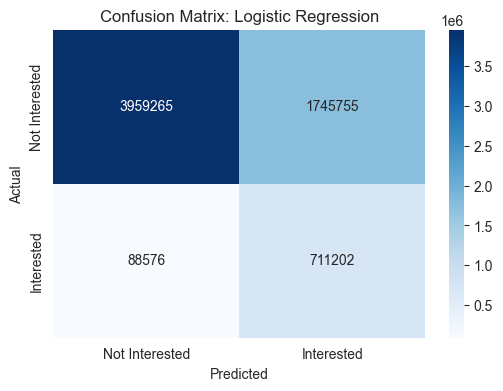

              precision    recall  f1-score   support

           0       0.98      0.69      0.81   5705020
           1       0.29      0.89      0.44    799778

    accuracy                           0.72   6504798
   macro avg       0.63      0.79      0.62   6504798
weighted avg       0.89      0.72      0.77   6504798

F1 Binary: 0.4368
F1 Macro: 0.6243
F1 Weighted: 0.7658
ROC AUC: 0.7916


In [50]:
# Logistic Regression
log_model.fit(X_res, y_res)
evaluate_model(log_model, "Logistic Regression", X_test, y_test)



--- Decision Tree ---


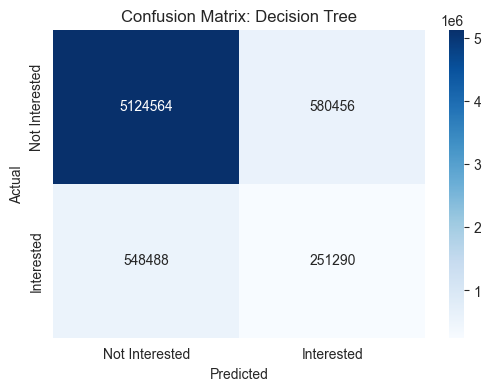

              precision    recall  f1-score   support

           0       0.90      0.90      0.90   5705020
           1       0.30      0.31      0.31    799778

    accuracy                           0.83   6504798
   macro avg       0.60      0.61      0.60   6504798
weighted avg       0.83      0.83      0.83   6504798

F1 Binary: 0.3080
F1 Macro: 0.6044
F1 Weighted: 0.8279
ROC AUC: 0.6062


In [51]:
# Decision Tree
tree_model.fit(X_res, y_res)
evaluate_model(tree_model, "Decision Tree", X_test, y_test)


--- Random Forest ---


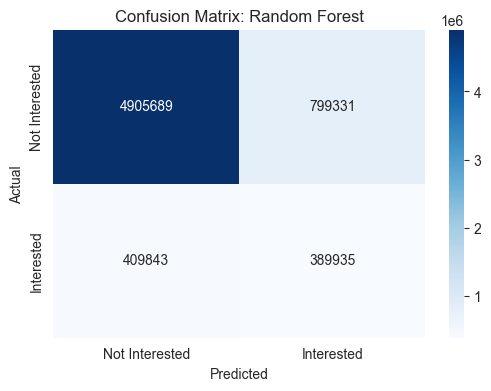

              precision    recall  f1-score   support

           0       0.92      0.86      0.89   5705020
           1       0.33      0.49      0.39    799778

    accuracy                           0.81   6504798
   macro avg       0.63      0.67      0.64   6504798
weighted avg       0.85      0.81      0.83   6504798

F1 Binary: 0.3921
F1 Macro: 0.6412
F1 Weighted: 0.8290
ROC AUC: 0.6737


In [59]:
# Random Forest
rf_model.fit(X_res, y_res)
evaluate_model(rf_model, "Random Forest", X_test, y_test)

C:\Users\shkva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:41:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost ---


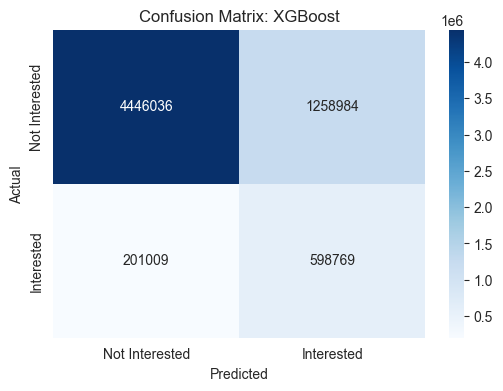

              precision    recall  f1-score   support

           0       0.96      0.78      0.86   5705020
           1       0.32      0.75      0.45    799778

    accuracy                           0.78   6504798
   macro avg       0.64      0.76      0.65   6504798
weighted avg       0.88      0.78      0.81   6504798

F1 Binary: 0.4506
F1 Macro: 0.6548
F1 Weighted: 0.8088
ROC AUC: 0.7640


In [53]:
# XGBoost
xgb_model.fit(X_res, y_res)
evaluate_model(xgb_model, "XGBoost", X_test, y_test)

[LightGBM] [Info] Number of positive: 87694, number of negative: 87694
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1017
[LightGBM] [Info] Number of data points in the train set: 175388, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

--- LightGBM ---


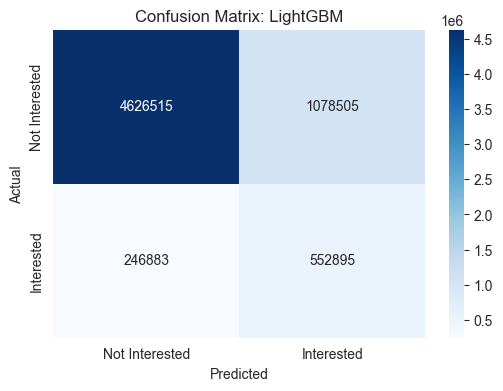

              precision    recall  f1-score   support

           0       0.95      0.81      0.87   5705020
           1       0.34      0.69      0.45    799778

    accuracy                           0.80   6504798
   macro avg       0.64      0.75      0.66   6504798
weighted avg       0.87      0.80      0.82   6504798

F1 Binary: 0.4548
F1 Macro: 0.6648
F1 Weighted: 0.8231
ROC AUC: 0.7511


In [54]:
# LightGBM
lgb_model.fit(X_res, y_res)
evaluate_model(lgb_model, "LightGBM", X_test, y_test)

Сравнительная таблица моделей

In [60]:
display_model_comparison()


--- Model Comparison ---


,Model,F1 Binary,F1 Macro,F1 Weighted,ROC AUC,Precision,Recall
2,Random Forest,0.390386,0.640746,0.829541,0.671625,0.328404,0.481206
5,Random Forest,0.392083,0.641181,0.829026,0.673722,0.327879,0.487554
1,Decision Tree,0.308043,0.604411,0.827901,0.606227,0.302123,0.314200
4,LightGBM,0.454837,0.664773,0.823084,0.751133,0.338908,0.691311
3,XGBoost,0.450621,0.654793,0.808759,0.763994,0.322308,0.748669
0,Logistic Regression,0.436758,0.624338,0.765792,0.791623,0.289465,0.889249
